#### Imports

In [19]:
import re, spacy, pytextrank
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from textblob import TextBlob
from wordcloud import WordCloud
from summa import keywords
from collections import Counter

#### Load data

In [2]:
# load data
df = pd.read_csv('data/elonmusk_tweets.csv')
df

,id,created_at,text
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa..."
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'"
3,848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...'
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ..."
...,...,...,...
2814,142881284019060736,2011-12-03 08:22:07,b'That was a total non sequitur btw'
2815,142880871391838208,2011-12-03 08:20:28,"b'Great Voltaire quote, arguably better than T..."
2816,142188458125963264,2011-12-01 10:29:04,b'I made the volume on the Model S http://t.co...
2817,142179928203460608,2011-12-01 09:55:11,"b""Went to Iceland on Sat to ride bumper cars o..."


#### Define functions

In [3]:
# initialize stopwords
stopwords = stopwords.words('english')
# initialize spacy
nlp = spacy.load('en_core_web_sm')

In [26]:
# clean the text by removing special characters
def text_clean(text):
    text = re.sub(r'http\S+', '', text)        # remove url link
    text = re.sub(r'@[a-zA-Z0-9]+', '', text)  # remove twitter username
    text = re.sub(r'#', '', text)              # remove #
    text = re.sub(r"b'", '', text)             # remove b'
    text = re.sub(r'b"', '', text)             # remove b"
    text = re.sub(r'RT', '', text)
    return text

# remove stopwords and lemmatization
def text_process(text):
    filtered_token = []                          # array used to store processed tokens
    postags = ['NOUN', 'ADJ', 'VERB', 'ADV']     # postags for lemmatization
    # use nltk to tokenize words
    for token in word_tokenize(text):           
        token = token.lower()                    # convert all to lowercase
        # ensure token is alphabetical and not stopword
        if token.isalpha() and token not in stopwords:
            spacy_doc = nlp(token)               # convert to spacy doc 
            for spacy_token in spacy_doc:        # convert to spacy token
                # append lemmatized token if not append original token
                filtered_token.append(spacy_token.lemma_ if spacy_token.pos_ in postags else token)
    # return lemmatized and stopwords removed version of tweet
    return ' '.join(token for token in filtered_token)

# calculate subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity  # return subjectivity score

# calculate polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity      # return polarity score

# sentiment based on polarity score
def sentiment_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

# visualization
def wordcloud_visual(text):
    # convert strings to single string
    words = ' '.join(tweet for tweet in text)
    # create word cloud based on all words
    word_cloud = WordCloud(width=500, 
                           height=300, 
                           random_state=21, 
                           max_font_size=119,
                           background_color='white').generate(words)
    # display word cloud
    plt.figure(figsize=(10,7))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# calculate keywords using textrank
def textrank_keywords(text, n_words=20):
    # Params
    # text      - series of tweets
    # n_words   - number of keywords will generate
    tweets = '. '.join(tweet for tweet in text)                 # convert strings to single string
    return keywords.keywords(tweets, words=n_words).split('\n') # return keywords based on textrank

# find top n most frequent occurred words
def frequent_words(text, n_words=20):
    # Params
    # text      - series of tweets
    # n_words   - top n most frequent words will generate
    words = ' '.join(tweet for tweet in text).split(' ')
    word_count = {}
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
    ordered_words = Counter(word_count)
    word, count = [], []
    for key, val in ordered_words.most_common(n_words):
        word.append(key)
        count.append(val)
    return pd.DataFrame(data={'Word': word, 'Frequency': count})

#### Sentiment analysis

In [5]:
df['tweet'] = df['text'].apply(text_clean)                 # cleaned text
df['tweet'] = df['tweet'].apply(text_process)              # removed stopwords and lemmatized
df['subjectivity'] = df['tweet'].apply(get_subjectivity)   # calculated subjectivity score
df['polarity'] = df['tweet'].apply(get_polarity)           # calculated polarity score
df['sentiment'] = df['polarity'].apply(sentiment_analysis) # generated sentiment

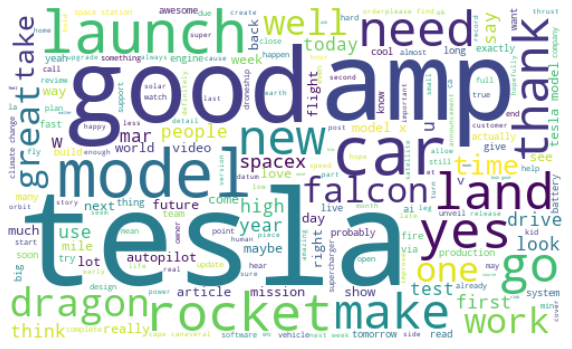

In [6]:
# generate word cloud for a brief overview of top words
wordcloud_visual(df['tweet'])

In [7]:
# inspect
df

,id,created_at,text,tweet,subjectivity,polarity,sentiment
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...,robot spare humanity,0.0000,0.0000,Neutral
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa...",exactly tesla absurdly overvalue base past,0.6250,-0.3250,Negative
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",et tu walt,0.0000,0.0000,Neutral
3,848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...',stormy weather shortville,0.0000,0.0000,Neutral
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ...",coal die due nat gas fracke basically dead,0.3875,-0.1625,Negative
...,...,...,...,...,...,...,...
2814,142881284019060736,2011-12-03 08:22:07,b'That was a total non sequitur btw',total non sequitur btw,0.7500,0.0000,Neutral
2815,142880871391838208,2011-12-03 08:20:28,"b'Great Voltaire quote, arguably better than T...",great voltaire quote arguably well twain hear ...,0.7000,0.5750,Positive
2816,142188458125963264,2011-12-01 10:29:04,b'I made the volume on the Model S http://t.co...,make volume model go need work miniature stone...,0.0000,0.0000,Neutral
2817,142179928203460608,2011-12-01 09:55:11,"b""Went to Iceland on Sat to ride bumper cars o...",go iceland sit ride bumper car ice country vla...,0.6000,0.6500,Positive


#### Popular keywords

In [8]:
# calculate top 20 keywords using textrank algo
keywords = textrank_keywords(df['tweet'], 20)
keywords

['tesla',
 'amp',
 'model',
 'good',
 'goodness',
 'car',
 'likely',
 'like dragon',
 'rocket',
 'launch',
 'yes',
 'need',
 'make',
 'land thank',
 'new',
 'great',
 'greatly',
 'landing',
 'time',
 'timing',
 'test',
 'testing',
 'work',
 'falcon']

#### Data extraction

In [30]:
# number of tweets in different sentiment groups
dt1 = df['sentiment'].value_counts().reset_index()
dt1.columns = ['Sentiment', 'Count']
# number of appearance for popular words
dt2 = frequent_words(df['tweet'], 20)

In [28]:
dt1.to_csv('data/sentiment_count.csv', index=False)
dt2.to_csv('data/frequent_words.csv', index=False)
df.to_csv('data/elon_tweets.csv', index=False)